<a href="https://colab.research.google.com/github/Nandini-007/Text-Analysis/blob/master/Text_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn

In [ ]:
!pip install syllapy

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import syllapy
import os
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load positive and negative words (you can expand these sets with actual lists of positive and negative words)
positive_words = set(["good", "happy", "joyful", "excellent", "positive", "fortunate", "correct", "superior"])
negative_words = set(["bad", "sad", "painful", "terrible", "negative", "unfortunate", "wrong", "inferior"])

# Function to count syllables in a word
def count_syllables(word):
    return syllapy.count(word)

# Function to check if a word is complex (more than 2 syllables)
def is_complex(word):
    return count_syllables(word) > 2

# Load the Excel file with the URLs
input_file = '/content/Input.xlsx'
output_structure_file = '/content/Output Data Structure.xlsx'
output_text_dir = '/mnt/data/scraped_texts/'

# Ensure the output directory exists
os.makedirs(output_text_dir, exist_ok=True)

try:
    input_df = pd.read_excel(input_file)
    output_structure = pd.read_excel(output_structure_file)

    # Define the columns based on the output structure
    columns = output_structure.columns

    # Function to scrape title and text from a given URL
    def scrape_article_from_url(url):
        try:
            response = requests.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')

            # Extract the title (adjust the tag and class based on the website's HTML structure)
            title = soup.find('h1')  # Most article titles are within <h1> tags
            title = title.get_text(strip=True) if title else 'No title found'

            # Extract the article text (adjust the tag and class based on the website's HTML structure)
            article_body = soup.find('div', class_='td-post-content')  # Example for articles within <div class="td-post-content">
            if not article_body:
                article_body = soup.find('article')  # Fallback to a generic <article> tag

            article_text = article_body.get_text(separator=' ', strip=True) if article_body else 'No article text found'
            return title, article_text
        except Exception as e:
            return 'Error', str(e)

    # Function to perform textual analysis
    def analyze_text(text):
        words = word_tokenize(text.lower())
        sentences = sent_tokenize(text)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.isalnum() and word not in stop_words]

        word_count = len(words)
        sentence_count = len(sentences)
        complex_words = [word for word in words if is_complex(word)]
        complex_word_count = len(complex_words)
        syllables_per_word = sum(count_syllables(word) for word in words) / word_count if word_count else 0
        avg_sentence_length = word_count / sentence_count if sentence_count else 0
        percentage_complex_words = complex_word_count / word_count if word_count else 0
        fog_index = 0.4 * (avg_sentence_length + percentage_complex_words)
        avg_word_length = sum(len(word) for word in words) / word_count if word_count else 0

        positive_score = sum(1 for word in words if word in positive_words)
        negative_score = sum(1 for word in words if word in negative_words)
        polarity_score = (positive_score - negative_score) / ((positive_score + negative_score) + 0.000001)
        subjectivity_score = (positive_score + negative_score) / (word_count + 0.000001)

        personal_pronouns = len(re.findall(r'\b(I|we|my|ours|us)\b', text, re.I))

        return {
            'positive_score': positive_score,
            'negative_score': negative_score,
            'polarity_score': polarity_score,
            'subjectivity_score': subjectivity_score,
            'avg_sentence_length': avg_sentence_length,
            'percentage_complex_words': percentage_complex_words,
            'fog_index': fog_index,
            'avg_number_words_per_sentence': avg_sentence_length,
            'complex_word_count': complex_word_count,
            'word_count': word_count,
            'syllables_per_word': syllables_per_word,
            'personal_pronouns': personal_pronouns,
            'avg_word_length': avg_word_length
        }

    # Scrape and analyze text for each URL in the Excel file
    scraped_data = []
    for index, row in input_df.iterrows():
        url = row['URL']
        url_id = row['URL_ID']
        title, text = scrape_article_from_url(url)

        # Save the extracted text to a file named after the URL_ID
        with open(f"{output_text_dir}{url_id}.txt", 'w') as file:
            file.write(f"Title: {title}\n\n{text}")

        analysis = analyze_text(text)
        scraped_data.append({
            'URL_ID': url_id,
            'URL': url,
            'Title': title,
'Text': text,
            'POSITIVE SCORE': analysis['positive_score'],
            'NEGATIVE SCORE': analysis['negative_score'],
            'POLARITY SCORE': analysis['polarity_score'],
            'SUBJECTIVITY SCORE': analysis['subjectivity_score'],
            'AVG SENTENCE LENGTH': analysis['avg_sentence_length'],
            'PERCENTAGE OF COMPLEX WORDS': analysis['percentage_complex_words'],
            'FOG INDEX': analysis['fog_index'],
            'AVG NUMBER OF WORDS PER SENTENCE': analysis['avg_number_words_per_sentence'],
            'COMPLEX WORD COUNT': analysis['complex_word_count'],
            'WORD COUNT': analysis['word_count'],
            'SYLLABLE PER WORD': analysis['syllables_per_word'],
            'PERSONAL PRONOUNS': analysis['personal_pronouns'],
            'AVG WORD LENGTH': analysis['avg_word_length']
        })
        print(f"Processed URL {index+1}/{len(input_df)}")

    # Create a DataFrame with the scraped and analyzed data
    df = pd.DataFrame(scraped_data)

    # Ensure the DataFrame columns are in the exact order as the output structure
    df = df[columns]

    # Save the DataFrame to an Excel file
    output_file_path = '/mnt/data/analyzed_output.xlsx'
    df.to_excel(output_file_path, index=False)

    print(f"Scraped and analyzed data has been saved to {output_file_path}")

except Exception as e:
    print(f"Error: {e}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Processed URL 1/147
Processed URL 2/147
Processed URL 3/147
Processed URL 4/147
Processed URL 5/147
Processed URL 6/147
Processed URL 7/147
Processed URL 8/147
Processed URL 9/147
Processed URL 10/147
Processed URL 11/147
Processed URL 12/147
Processed URL 13/147
Processed URL 14/147
Processed URL 15/147
Processed URL 16/147
Processed URL 17/147
Processed URL 18/147
Processed URL 19/147
Processed URL 20/147
Processed URL 21/147
Processed URL 22/147
Processed URL 23/147
Processed URL 24/147
Processed URL 25/147
Processed URL 26/147
Processed URL 27/147
Processed URL 28/147
Processed URL 29/147
Processed URL 30/147
Processed URL 31/147
Processed URL 32/147
Processed URL 33/147
Processed URL 34/147
Processed URL 35/147
Processed URL 36/147
Processed URL 37/147
Processed URL 38/147
Processed URL 39/147
Processed URL 40/147
Processed URL 41/147
Processed URL 42/147
Processed URL 43/147
Processed URL 44/147
Processed URL 45/147
Processed URL 46/147
Processed URL 47/147
Processed URL 48/147
P

In [ ]:
print(df.columns)
columns=['POSITIVE SCORE', 'NEGATIVE SCORE', 'POLARITY SCORE', 'SUBJECTIVITY SCORE', 'AVG SENTENCE LENGTH', 'PERCENTAGE OF COMPLEX WORDS', 'FOG INDEX', 'AVG NUMBER OF WORDS PER SENTENCE', 'COMPLEX WORD COUNT', 'WORD COUNT', 'SYLLABLE PER WORD', 'PERSONAL PRONOUNS', 'AVG WORD LENGTH']

Index(['URL_ID', 'URL', 'Title', 'Text', 'Positive Score', 'Negative Score',
       'Polarity Score', 'Subjectivity Score', 'Avg Sentence Length',
       'Percentage of Complex Words', 'Fog Index',
       'Avg Number of Words Per Sentence', 'Complex Word Count', 'Word Count',
       'Syllables Per Word', 'Personal Pronouns', 'Avg Word Length'],
      dtype='object')


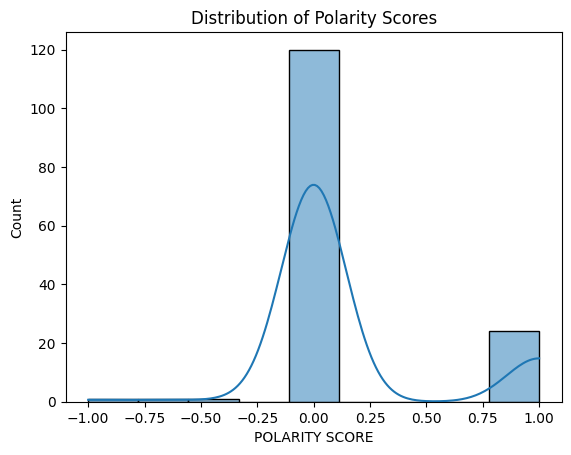

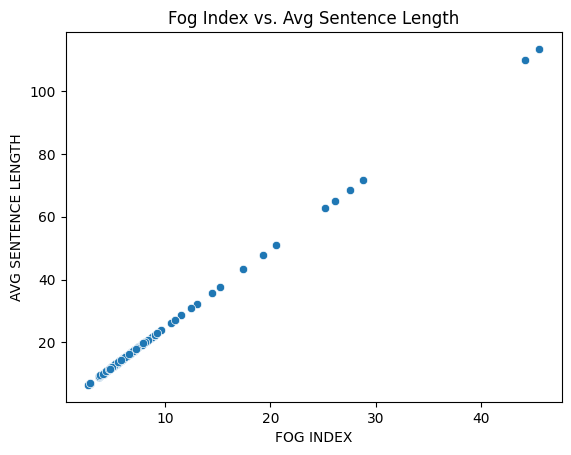

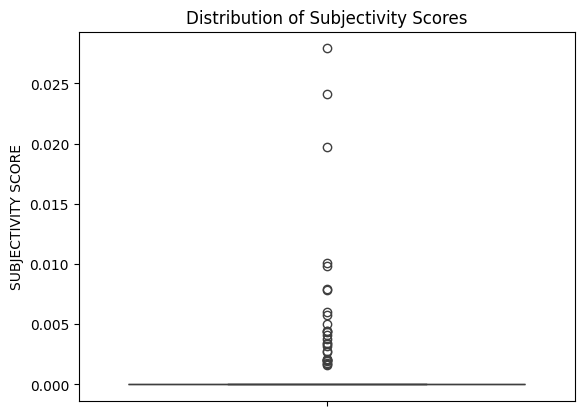

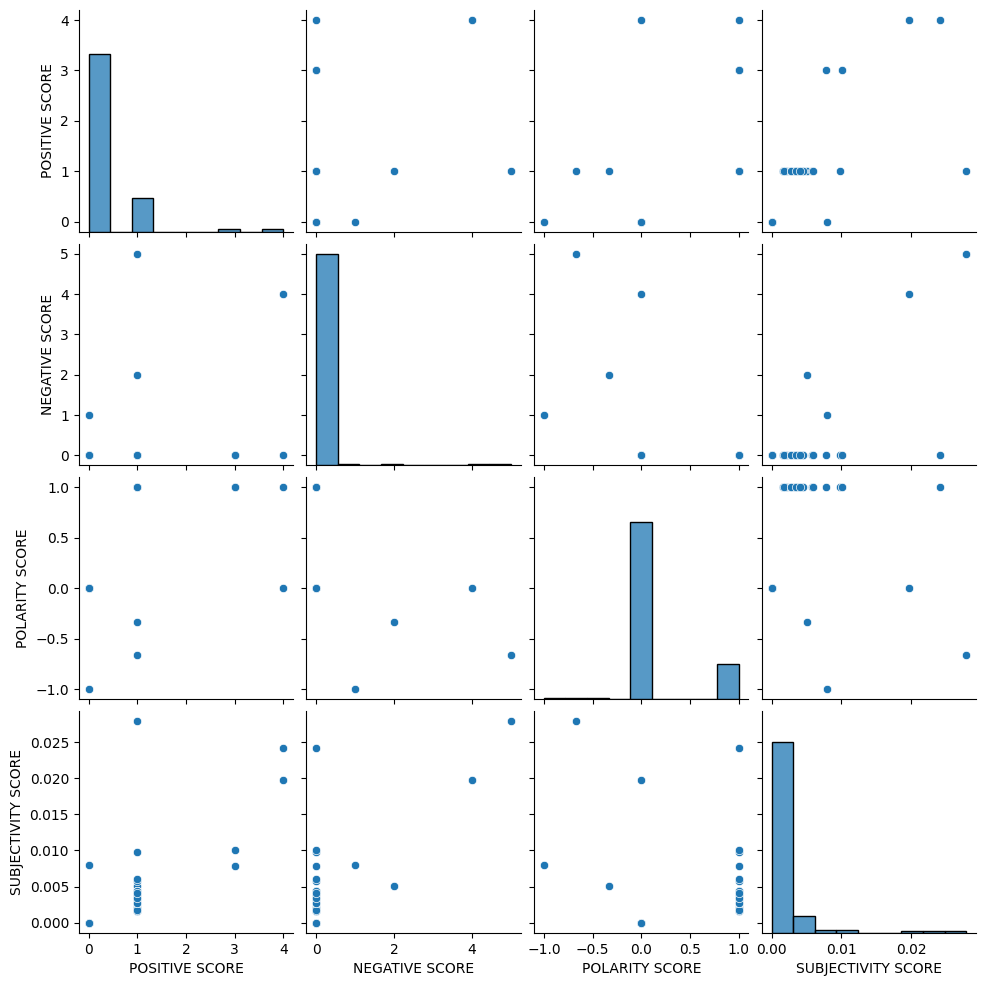

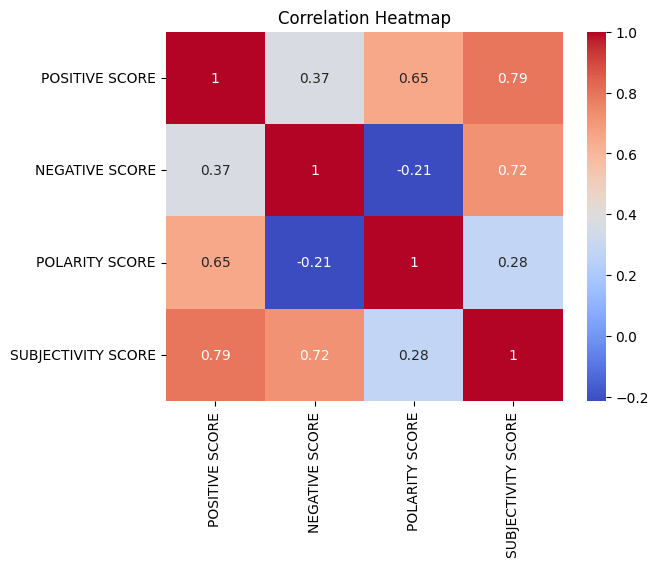

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Polarity Scores
sns.histplot(df['POLARITY SCORE'], kde=True)
plt.title('Distribution of Polarity Scores')
plt.show()

# Relationship between Fog Index and Avg Sentence Length
sns.scatterplot(x='FOG INDEX', y='AVG SENTENCE LENGTH', data=df)
plt.title('Fog Index vs. Avg Sentence Length')
plt.show()
# Boxplot of Subjectivity Scores
sns.boxplot(y='SUBJECTIVITY SCORE', data=df)
plt.title('Distribution of Subjectivity Scores')
plt.show()

# Pairplot for selected features
sns.pairplot(df[['POSITIVE SCORE', 'NEGATIVE SCORE', 'POLARITY SCORE', 'SUBJECTIVITY SCORE']])
plt.show()

# Heatmap for correlation
correlation_matrix = df[['POSITIVE SCORE', 'NEGATIVE SCORE', 'POLARITY SCORE', 'SUBJECTIVITY SCORE']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()